
# Hybrid with 7 years data

In [1]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, Attention, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.regularizers import l2
import matplotlib.pyplot as plt

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)


In [3]:
# Load and preprocess the data
df = pd.read_csv('7new30.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date').reset_index(drop=True)
df.dropna(inplace=True)

In [4]:
# List of features
FEATURES = ['Price', 'Open', 'High', 'Low', 'GDP', 'Inflation', 'FDI', 'Trade Balance', 'Unemployment Rate', 'Exchange Rate', 'Economic Growth']
data_filtered = df[FEATURES]

#  Scaling data

In [5]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_filtered)

In [6]:
# Sequence length for time series
sequence_length = 10

In [7]:
# Partition dataset into input sequences (X) and target values (y)
def partition_dataset(sequence_length, data):
    x, y = [], []
    for i in range(sequence_length, len(data)):
        x.append(data[i-sequence_length:i, :])
        y.append(data[i, 0])  # 'Price' as the target
    return np.array(x), np.array(y)

x, y = partition_dataset(sequence_length, data_scaled)
split = int(0.8 * len(x))
x_train, y_train = x[:split], y[:split]
x_test, y_test = x[split:], y[split:]

In [8]:
# Learning Rate Scheduler
def lr_scheduler(epoch, lr):
    if epoch > 10:
        return lr * 0.9  # Slightly decrease learning rate after 10 epochs
    return lr

In [9]:
# Attention mechanism - Self-Attention Layer
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return attention

# Additional Attention Layer for hybrid approach (Post-CNN)
def post_cnn_attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return attention

# Build the enhanced LSTM-CNN model with hybrid attention and L2 regularization
def build_lstm_cnn_model(input_shape):
    inputs = Input(shape=input_shape)

    # First Bidirectional LSTM layer
    lstm_out = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    lstm_out = Dropout(0.01)(lstm_out)

    # Second Bidirectional LSTM layer
    lstm_out = Bidirectional(LSTM(74, return_sequences=True))(lstm_out)
    lstm_out = Dropout(0.01)(lstm_out)

    # Third Bidirectional LSTM layer
    lstm_out = Bidirectional(LSTM(32, return_sequences=True))(lstm_out)
    lstm_out = Dropout(0.01)(lstm_out)

    # Attention mechanism after LSTM layers (Self-Attention)
    attention_out = attention_layer(lstm_out)

    # Convolutional layer with max pooling
    cnn_out = Conv1D(filters=64, kernel_size=3, activation='relu')(attention_out)
    cnn_out = MaxPooling1D(pool_size=2)(cnn_out)

    # Hybrid Attention Mechanism: Apply attention after CNN
    post_cnn_attention_out = post_cnn_attention_layer(cnn_out)

    # Flatten the output of CNN + Attention before feeding into dense layers
    flat_out = Flatten()(post_cnn_attention_out)

    # Fully connected layers with L2 regularization
    dense_out = Dense(128, activation='relu', kernel_regularizer=l2(0.00001))(flat_out)
    dense_out = Dropout(0.01)(dense_out)
    dense_out = Dense(64, activation='relu', kernel_regularizer=l2(0.00001))(dense_out)
    outputs = Dense(1, kernel_regularizer=l2(0.00001))(dense_out)

    model = Model(inputs, outputs)
    return model

# Initialize the model
model = build_lstm_cnn_model((x_train.shape[1], x_train.shape[2]))

In [10]:
# Compile the model with Adam optimizer and a reduced learning rate
optimizer = Adam(learning_rate=0.0000591)  # Reduced the learning rate for more precise learning
model.compile(optimizer=optimizer, loss='mse')

In [11]:
# Define callbacks: Early Stopping, ReduceLROnPlateau, and LearningRateScheduler for optimization
early_stop = EarlyStopping(monitor='val_loss', patience=50, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
lr_schedule = LearningRateScheduler(lr_scheduler)

In [13]:
# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=16, validation_split=0.1,
                    callbacks=[early_stop, reduce_lr, lr_schedule], verbose=1)

Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - loss: 0.1017 - val_loss: 0.0065 - learning_rate: 5.9100e-05
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0066 - val_loss: 0.0037 - learning_rate: 5.9100e-05
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0033 - val_loss: 0.0035 - learning_rate: 5.9100e-05
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0030 - val_loss: 0.0035 - learning_rate: 5.9100e-05
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0.0029 - val_loss: 0.0034 - learning_rate: 5.9100e-05
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0028 - val_loss: 0.0035 - learning_rate: 5.9100e-05
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0027 - val_loss: 0.0033 - learning_rate: 5.9100e-05
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0027 - val_loss: 0.0032 - learning_rate: 5.9100e-05
Epoch 9/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0026 - val_loss: 0.0032 - learning

In [14]:
# Evaluate model performance
y_pred_scaled = model.predict(x_test)
y_pred = scaler.inverse_transform(np.concatenate((y_pred_scaled, x_test[:, -1, 1:]), axis=1))[:, 0]
y_test_unscaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), x_test[:, -1, 1:]), axis=1))[:, 0]

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [15]:
# Compute evaluation metrics
mse = mean_squared_error(y_test_unscaled, y_pred)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test_unscaled - y_pred))
mape = np.mean(np.abs((y_test_unscaled - y_pred) / y_test_unscaled)) * 100
# Results
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape:.2f}%')

MSE: 2258.58
RMSE: 47.52
MAE: 36.62
MAPE: 1.49%


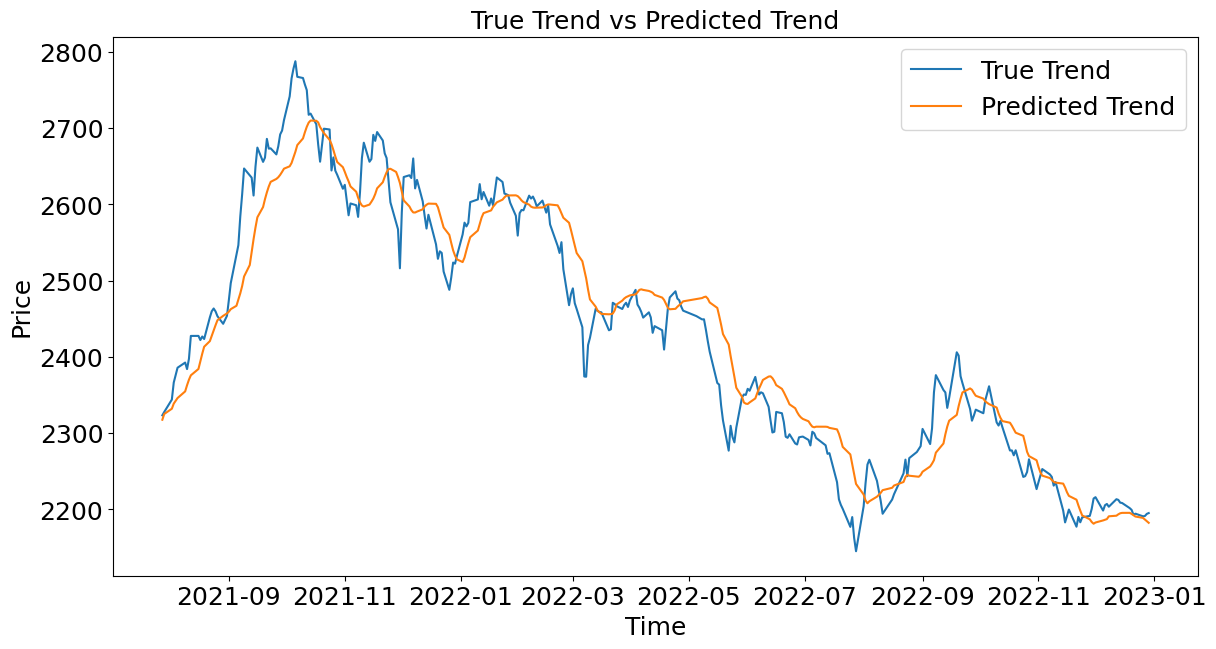

In [16]:
# Plot predictions vs actual prices
plt.figure(figsize=(14, 7))
plt.plot(df['Date'].iloc[-len(y_test_unscaled):], y_test_unscaled, label='True Trend')
plt.plot(df['Date'].iloc[-len(y_pred):], y_pred, label='Predicted Trend')
plt.title('True Trend vs Predicted Trend', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.tick_params(axis='both', labelsize=18)
plt.legend(fontsize=18)
plt.show()

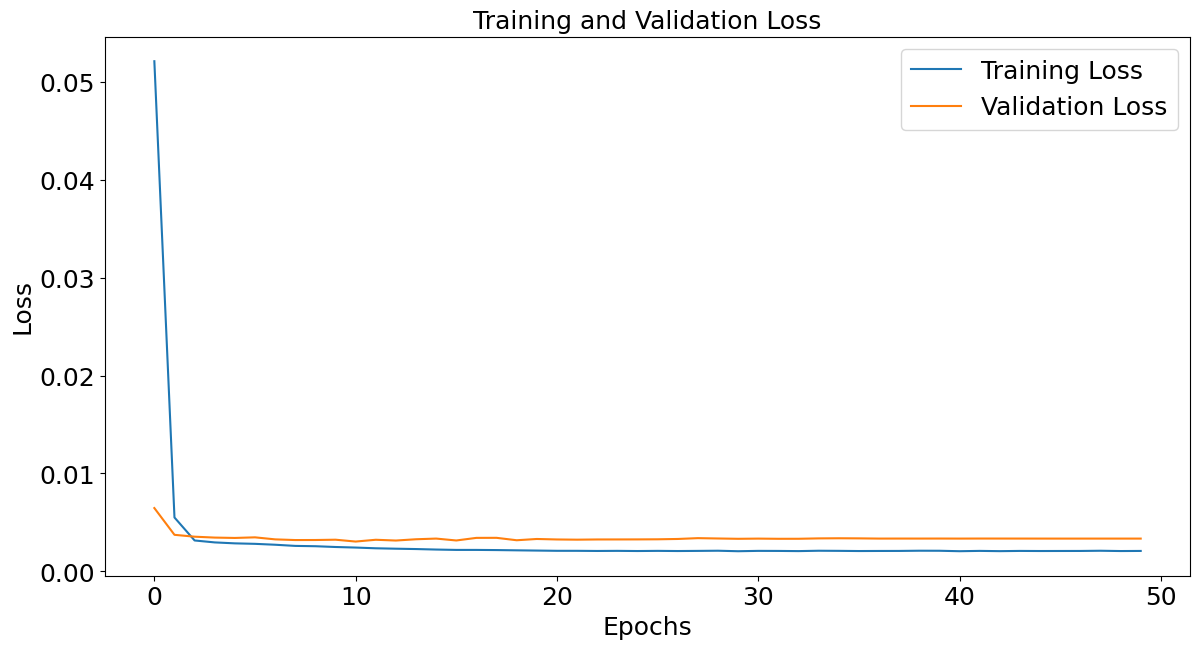

In [17]:
# Plot loss curve (training and validation loss)
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=18)
plt.tick_params(axis='both', labelsize=18)
plt.show()

In [18]:
# Calculate prediction accuracy
absolute_difference = np.abs(y_test_unscaled - y_pred)
mean_absolute_difference = np.mean(absolute_difference)
price_range = np.max(y_test_unscaled) - np.min(y_test_unscaled)
accuracy_percentage = (1 - (mean_absolute_difference / price_range)) * 100
print(f'Accuracy of Predicted Prices: {accuracy_percentage:.2f}%')


Accuracy of Predicted Prices: 94.30%


# Hybrid with 10 years data

In [19]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, Attention, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.regularizers import l2
import matplotlib.pyplot as plt

In [20]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)


In [21]:
# Load and preprocess the data
df = pd.read_csv('new30.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date').reset_index(drop=True)
df.dropna(inplace=True)


In [22]:
# List of features
FEATURES = ['Price', 'Open', 'High', 'Low', 'GDP', 'Inflation', 'FDI', 'Trade Balance', 'Unemployment Rate', 'Exchange Rate', 'Economic Growth']
data_filtered = df[FEATURES]

In [23]:
# Scaling data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_filtered)

In [24]:
# Sequence length for time series
sequence_length = 10

In [25]:
# Partition dataset into input sequences (X) and target values (y)
def partition_dataset(sequence_length, data):
    x, y = [], []
    for i in range(sequence_length, len(data)):
        x.append(data[i-sequence_length:i, :])
        y.append(data[i, 0])  # 'Price' as the target
    return np.array(x), np.array(y)

x, y = partition_dataset(sequence_length, data_scaled)
split = int(0.8 * len(x))
x_train, y_train = x[:split], y[:split]
x_test, y_test = x[split:], y[split:]

In [26]:
# Learning Rate Scheduler
def lr_scheduler(epoch, lr):
    if epoch > 10:
        return lr * 0.9  # Slightly decrease learning rate after 10 epochs
    return lr


In [27]:
# Attention mechanism - Self-Attention Layer
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return attention

# Additional Attention Layer for hybrid approach (Post-CNN)
def post_cnn_attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return attention

# Build the enhanced LSTM-CNN model with hybrid attention and L2 regularization
def build_lstm_cnn_model(input_shape):
    inputs = Input(shape=input_shape)

    # First Bidirectional LSTM layer
    lstm_out = Bidirectional(LSTM(252, return_sequences=True))(inputs)
    lstm_out = Dropout(0.05)(lstm_out)

    # Second Bidirectional LSTM layer
    lstm_out = Bidirectional(LSTM(128, return_sequences=True))(lstm_out)
    #lstm_out = Dropout(0.05)(lstm_out)

    # Third Bidirectional LSTM layer
    lstm_out = Bidirectional(LSTM(72, return_sequences=True))(lstm_out)
    #lstm_out = Dropout(0.06)(lstm_out)

    # Attention mechanism after LSTM layers (Self-Attention)
    attention_out = attention_layer(lstm_out)

    # Convolutional layer with max pooling
    cnn_out = Conv1D(filters=64, kernel_size=3, activation='relu')(attention_out)
    cnn_out = MaxPooling1D(pool_size=2)(cnn_out)

    # Hybrid Attention Mechanism: Apply attention after CNN
    post_cnn_attention_out = post_cnn_attention_layer(cnn_out)

    # Flatten the output of CNN + Attention before feeding into dense layers
    flat_out = Flatten()(post_cnn_attention_out)

    # Fully connected layers with L2 regularization
    dense_out = Dense(128, activation='relu', kernel_regularizer=l2(0.00001))(flat_out)
    dense_out = Dropout(0.01)(dense_out)
    dense_out = Dense(64, activation='relu', kernel_regularizer=l2(0.00001))(dense_out)
    outputs = Dense(1, kernel_regularizer=l2(0.00001))(dense_out)

    model = Model(inputs, outputs)
    return model

# Initialize the model
model = build_lstm_cnn_model((x_train.shape[1], x_train.shape[2]))

In [28]:
# Compile the model with Adam optimizer and a reduced learning rate
optimizer = Adam(learning_rate=0.0000591)  # Reduced the learning rate for more precise learning
model.compile(optimizer=optimizer, loss='mse')


In [29]:
# Define callbacks: Early Stopping, ReduceLROnPlateau, and LearningRateScheduler for optimization
early_stop = EarlyStopping(monitor='val_loss', patience=50, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
lr_schedule = LearningRateScheduler(lr_scheduler)

In [30]:
# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=16, validation_split=0.1,
                    callbacks=[early_stop, reduce_lr, lr_schedule], verbose=1)

Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step - loss: 0.0761 - val_loss: 0.0079 - learning_rate: 5.9100e-05
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - loss: 0.0039 - val_loss: 0.0035 - learning_rate: 5.9100e-05
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - loss: 0.0032 - val_loss: 0.0034 - learning_rate: 5.9100e-05
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - loss: 0.0031 - val_loss: 0.0033 - learning_rate: 5.9100e-05
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - loss: 0.0029 - val_loss: 0.0030 - learning_rate: 5.9100e-05
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - loss: 0.0028 - val_loss: 0.0029 - learning_rate: 5.9100e-05
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - loss: 0.0027 - val_loss: 0.0028 - learning_rate: 5.9100e-05
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - loss: 0.0026 - val_loss: 0.0027 - learning_rate: 5.9100e-05
Epoch 9/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.0025 -

In [31]:
# Evaluate model performance
y_pred_scaled = model.predict(x_test)
y_pred = scaler.inverse_transform(np.concatenate((y_pred_scaled, x_test[:, -1, 1:]), axis=1))[:, 0]
y_test_unscaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), x_test[:, -1, 1:]), axis=1))[:, 0]

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step


In [32]:
# Compute evaluation metrics
mse = mean_squared_error(y_test_unscaled, y_pred)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test_unscaled - y_pred))
mape = np.mean(np.abs((y_test_unscaled - y_pred) / y_test_unscaled)) * 100

# Results
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape:.2f}%')

MSE: 3779.73
RMSE: 61.48
MAE: 49.58
MAPE: 2.11%


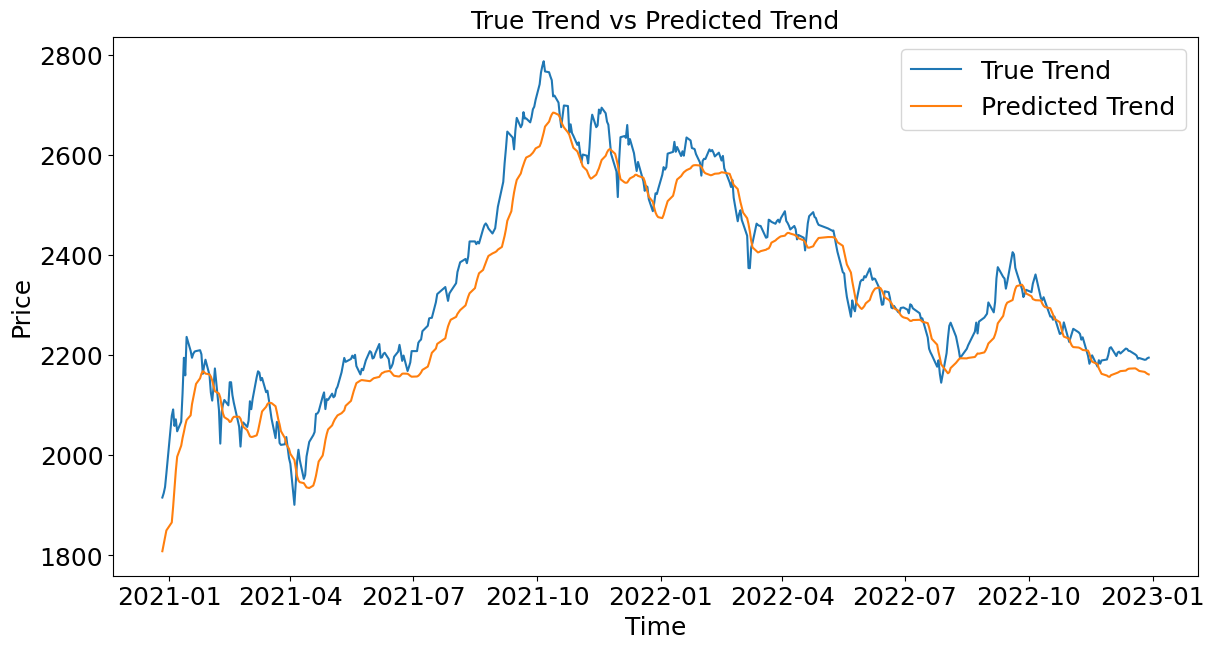

In [33]:
# Plot predictions vs actual prices
plt.figure(figsize=(14, 7))
plt.plot(df['Date'].iloc[-len(y_test_unscaled):], y_test_unscaled, label='True Trend')
plt.plot(df['Date'].iloc[-len(y_pred):], y_pred, label='Predicted Trend')
plt.title('True Trend vs Predicted Trend', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.tick_params(axis='both', labelsize=18)
plt.legend(fontsize=18)
plt.show()

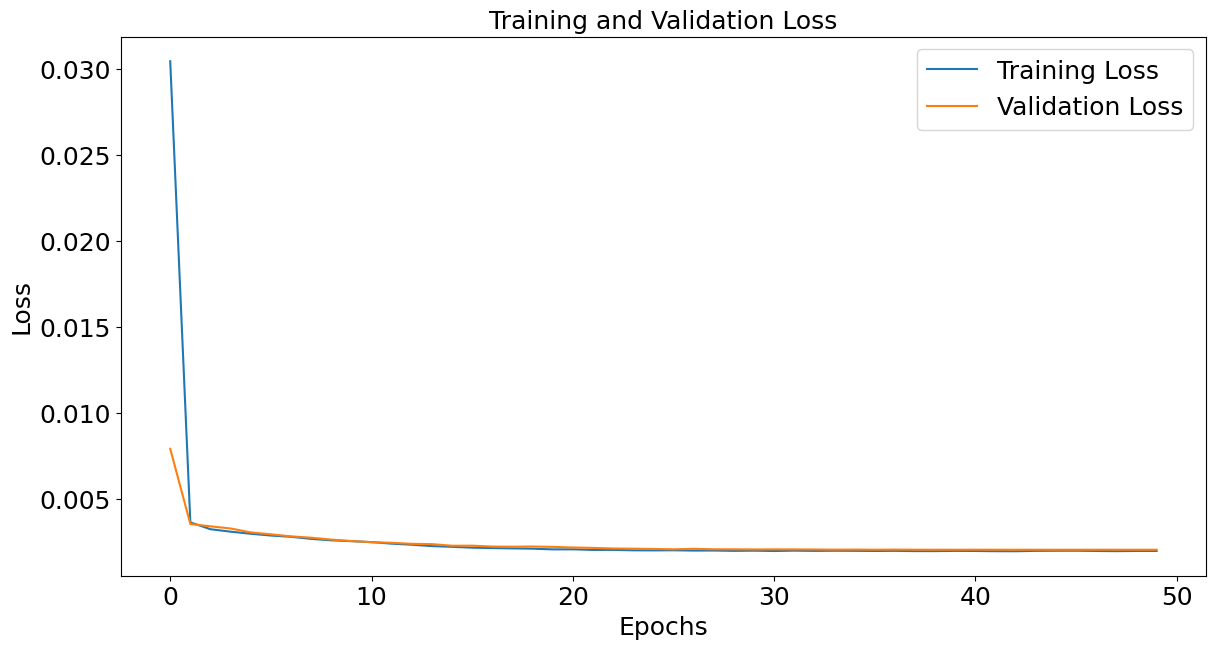

In [34]:
# Plot loss curve (training and validation loss)
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=18)
plt.tick_params(axis='both', labelsize=18)
plt.show()

In [35]:
# Calculate prediction accuracy
absolute_difference = np.abs(y_test_unscaled - y_pred)
mean_absolute_difference = np.mean(absolute_difference)
price_range = np.max(y_test_unscaled) - np.min(y_test_unscaled)
accuracy_percentage = (1 - (mean_absolute_difference / price_range)) * 100
print(f'Accuracy of Predicted Prices: {accuracy_percentage:.2f}%')

Accuracy of Predicted Prices: 94.41%


# 5years

           Date    Price     Open     High      Low  Change %   GDP  \
0    2018-01-01  2281.55  2281.55  2281.55  2281.55   -0.0007  7.32   
1    2018-01-02  2291.37  2291.37  2291.37  2291.37    0.0043  7.32   
2    2018-01-03  2301.81  2301.81  2301.81  2301.81    0.0046  7.32   
3    2018-01-04  2295.21  2295.21  2295.21  2295.21   -0.0029  7.32   
4    2018-01-07  2283.21  2283.21  2283.21  2283.21   -0.0052  7.32   
...         ...      ...      ...      ...      ...       ...   ...   
1146 2022-12-22  2194.51  2194.51  2194.51  2194.51    0.0007  7.10   
1147 2022-12-26  2191.01  2191.01  2191.01  2191.01   -0.0016  7.10   
1148 2022-12-27  2191.45  2191.45  2191.45  2191.45    0.0002  7.10   
1149 2022-12-28  2194.20  2194.20  2194.20  2194.20    0.0013  7.10   
1150 2022-12-29  2195.30  2195.30  2195.30  2195.30    0.0005  7.10   

      Inflation   FDI  Trade Balance  Unemployment Rate  Exchange Rate  \
0          5.54  2.42          23.03               4.38          84.50   

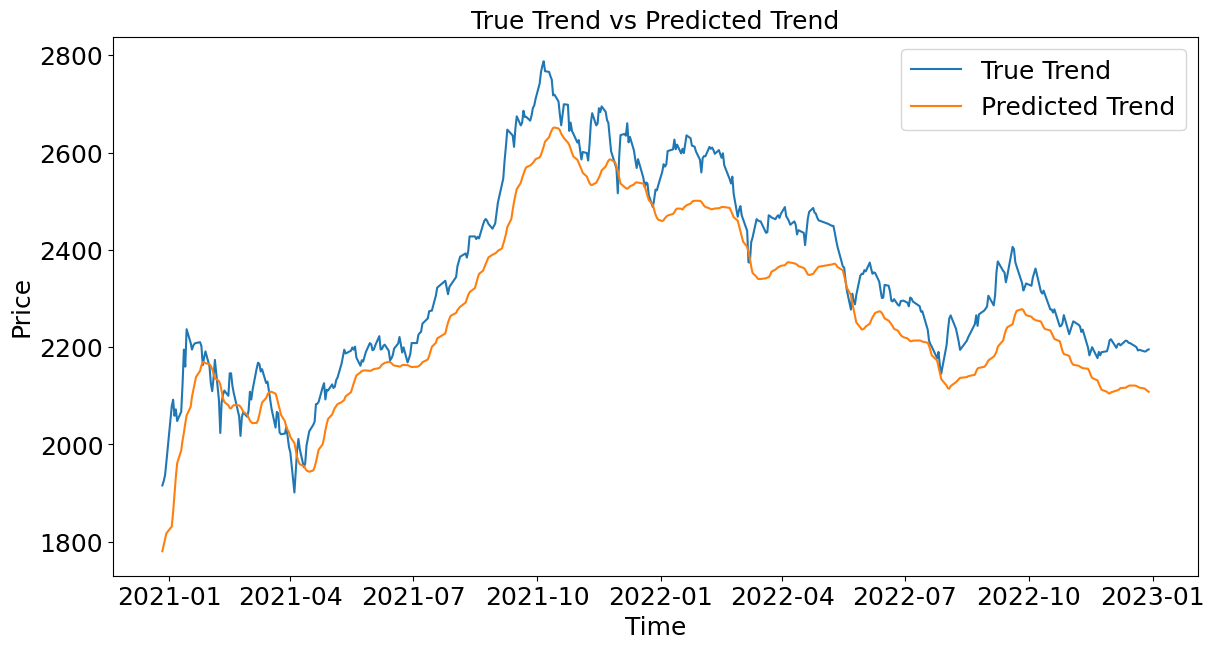

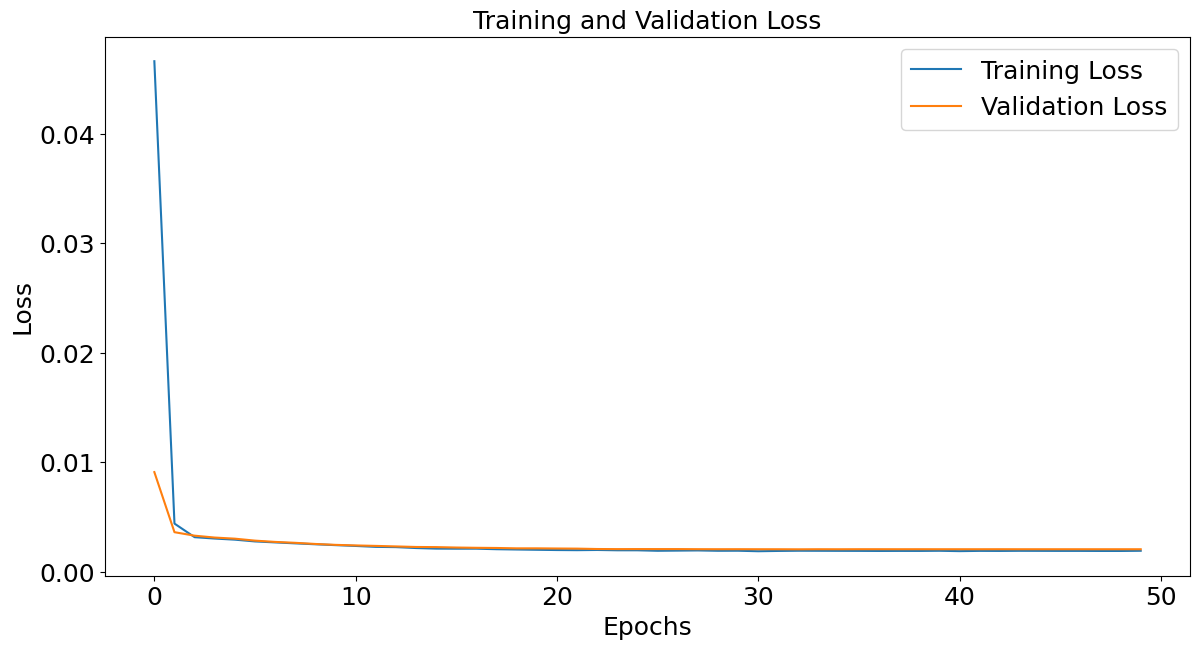

Accuracy of Predicted Prices: 91.28%


In [ ]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, Attention, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.regularizers import l2
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Load and preprocess the data
df = pd.read_csv('new30.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date').reset_index(drop=True)
df.dropna(inplace=True)


# Calculate the cutoff date for the last 5 years
latest_date = df['Date'].max()  # Most recent date in the dataset
cutoff_date = latest_date - pd.DateOffset(years=5)

# Filter the DataFrame for rows within the last 5 years
df_last_5_years = df[df['Date'] >= cutoff_date]

# Reset the index
df_last_5_years = df_last_5_years.reset_index(drop=True)

# Display the filtered DataFrame
print(df_last_5_years)





# List of features
FEATURES = ['Price', 'Open', 'High', 'Low', 'GDP', 'Inflation', 'FDI', 'Trade Balance', 'Unemployment Rate', 'Exchange Rate', 'Economic Growth']
data_filtered = df[FEATURES]

# Scaling data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_filtered)

# Sequence length for time series
sequence_length = 10

# Partition dataset into input sequences (X) and target values (y)
def partition_dataset(sequence_length, data):
    x, y = [], []
    for i in range(sequence_length, len(data)):
        x.append(data[i-sequence_length:i, :])
        y.append(data[i, 0])  # 'Price' as the target
    return np.array(x), np.array(y)

x, y = partition_dataset(sequence_length, data_scaled)
split = int(0.8 * len(x))
x_train, y_train = x[:split], y[:split]
x_test, y_test = x[split:], y[split:]

# Learning Rate Scheduler
def lr_scheduler(epoch, lr):
    if epoch > 10:
        return lr * 0.9  # Slightly decrease learning rate after 10 epochs
    return lr

# Attention mechanism - Self-Attention Layer
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return attention

# Additional Attention Layer for hybrid approach (Post-CNN)
def post_cnn_attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return attention

# Build the enhanced LSTM-CNN model with hybrid attention and L2 regularization
def build_lstm_cnn_model(input_shape):
    inputs = Input(shape=input_shape)

    # First Bidirectional LSTM layer
    lstm_out = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    lstm_out = Dropout(0.01)(lstm_out)

    # Second Bidirectional LSTM layer
    lstm_out = Bidirectional(LSTM(74, return_sequences=True))(lstm_out)
    lstm_out = Dropout(0.01)(lstm_out)

    # Third Bidirectional LSTM layer
    lstm_out = Bidirectional(LSTM(32, return_sequences=True))(lstm_out)
    lstm_out = Dropout(0.01)(lstm_out)

    # Attention mechanism after LSTM layers (Self-Attention)
    attention_out = attention_layer(lstm_out)

    # Convolutional layer with max pooling
    cnn_out = Conv1D(filters=64, kernel_size=3, activation='relu')(attention_out)
    cnn_out = MaxPooling1D(pool_size=2)(cnn_out)

    # Hybrid Attention Mechanism: Apply attention after CNN
    post_cnn_attention_out = post_cnn_attention_layer(cnn_out)

    # Flatten the output of CNN + Attention before feeding into dense layers
    flat_out = Flatten()(post_cnn_attention_out)

    # Fully connected layers with L2 regularization
    dense_out = Dense(128, activation='relu', kernel_regularizer=l2(0.00001))(flat_out)
    dense_out = Dropout(0.01)(dense_out)
    dense_out = Dense(64, activation='relu', kernel_regularizer=l2(0.00001))(dense_out)
    outputs = Dense(1, kernel_regularizer=l2(0.00001))(dense_out)

    model = Model(inputs, outputs)
    return model

# Initialize the model
model = build_lstm_cnn_model((x_train.shape[1], x_train.shape[2]))

# Compile the model with Adam optimizer and a reduced learning rate
optimizer = Adam(learning_rate=0.0000591)  # Reduced the learning rate for more precise learning
model.compile(optimizer=optimizer, loss='mse')

# Define callbacks: Early Stopping, ReduceLROnPlateau, and LearningRateScheduler for optimization
early_stop = EarlyStopping(monitor='val_loss', patience=50, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
lr_schedule = LearningRateScheduler(lr_scheduler)

# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=16, validation_split=0.1,
                    callbacks=[early_stop, reduce_lr, lr_schedule], verbose=1)

# Evaluate model performance
y_pred_scaled = model.predict(x_test)
y_pred = scaler.inverse_transform(np.concatenate((y_pred_scaled, x_test[:, -1, 1:]), axis=1))[:, 0]
y_test_unscaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), x_test[:, -1, 1:]), axis=1))[:, 0]

# Compute evaluation metrics
mse = mean_squared_error(y_test_unscaled, y_pred)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test_unscaled - y_pred))
mape = np.mean(np.abs((y_test_unscaled - y_pred) / y_test_unscaled)) * 100

# Results
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape:.2f}%')

# Plot predictions vs actual prices
plt.figure(figsize=(14, 7))
plt.plot(df['Date'].iloc[-len(y_test_unscaled):], y_test_unscaled, label='True Trend')
plt.plot(df['Date'].iloc[-len(y_pred):], y_pred, label='Predicted Trend')
plt.title('True Trend vs Predicted Trend', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.tick_params(axis='both', labelsize=18)
plt.legend(fontsize=18)
plt.show()


# Plot loss curve (training and validation loss)
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=18)
plt.tick_params(axis='both', labelsize=18)
plt.show()


# Calculate prediction accuracy
absolute_difference = np.abs(y_test_unscaled - y_pred)
mean_absolute_difference = np.mean(absolute_difference)
price_range = np.max(y_test_unscaled) - np.min(y_test_unscaled)
accuracy_percentage = (1 - (mean_absolute_difference / price_range)) * 100
print(f'Accuracy of Predicted Prices: {accuracy_percentage:.2f}%')


#**practice**




In [ ]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, Attention, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.regularizers import l2
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Load and preprocess the data
df = pd.read_csv('nse_all_stock_data (1).csv')
df.head()
df['Date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='Date').reset_index(drop=True)
df.dropna(inplace=True)
df.head()

print(f"DataFrame shape: {df.shape}")  # Shows number of rows and columns
if df.empty:
    print("The DataFrame is empty.")

# List of features
FEATURES = ['price]
data_filtered = df[FEATURES]

# Scaling data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_filtered)

# Sequence length for time series
sequence_length = 10

# Partition dataset into input sequences (X) and target values (y)
def partition_dataset(sequence_length, data):
    x, y = [], []
    for i in range(sequence_length, len(data)):
        x.append(data[i-sequence_length:i, :])
        y.append(data[i, 0])  # 'Price' as the target
    return np.array(x), np.array(y)

x, y = partition_dataset(sequence_length, data_scaled)
split = int(0.8 * len(x))
x_train, y_train = x[:split], y[:split]
x_test, y_test = x[split:], y[split:]

# Learning Rate Scheduler
def lr_scheduler(epoch, lr):
    if epoch > 10:
        return lr * 0.9  # Slightly decrease learning rate after 10 epochs
    return lr

# Attention mechanism - Self-Attention Layer
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return attention

# Additional Attention Layer for hybrid approach (Post-CNN)
def post_cnn_attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return attention

# Build the enhanced LSTM-CNN model with hybrid attention and L2 regularization
def build_lstm_cnn_model(input_shape):
    inputs = Input(shape=input_shape)

    # First Bidirectional LSTM layer
    lstm_out = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    lstm_out = Dropout(0.01)(lstm_out)

    # Second Bidirectional LSTM layer
    lstm_out = Bidirectional(LSTM(74, return_sequences=True))(lstm_out)
    lstm_out = Dropout(0.01)(lstm_out)

    # Third Bidirectional LSTM layer
    lstm_out = Bidirectional(LSTM(32, return_sequences=True))(lstm_out)
    lstm_out = Dropout(0.01)(lstm_out)

    # Attention mechanism after LSTM layers (Self-Attention)
    attention_out = attention_layer(lstm_out)

    # Convolutional layer with max pooling
    cnn_out = Conv1D(filters=64, kernel_size=3, activation='relu')(attention_out)
    cnn_out = MaxPooling1D(pool_size=2)(cnn_out)

    # Hybrid Attention Mechanism: Apply attention after CNN
    post_cnn_attention_out = post_cnn_attention_layer(cnn_out)

    # Flatten the output of CNN + Attention before feeding into dense layers
    flat_out = Flatten()(post_cnn_attention_out)

    # Fully connected layers with L2 regularization
    dense_out = Dense(128, activation='relu', kernel_regularizer=l2(0.00001))(flat_out)
    dense_out = Dropout(0.01)(dense_out)
    dense_out = Dense(64, activation='relu', kernel_regularizer=l2(0.00001))(dense_out)
    outputs = Dense(1, kernel_regularizer=l2(0.00001))(dense_out)

    model = Model(inputs, outputs)
    return model

# Initialize the model
model = build_lstm_cnn_model((x_train.shape[1], x_train.shape[2]))

# Compile the model with Adam optimizer and a reduced learning rate
optimizer = Adam(learning_rate=0.0000591)  # Reduced the learning rate for more precise learning
model.compile(optimizer=optimizer, loss='mse')

# Define callbacks: Early Stopping, ReduceLROnPlateau, and LearningRateScheduler for optimization
early_stop = EarlyStopping(monitor='val_loss', patience=50, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
lr_schedule = LearningRateScheduler(lr_scheduler)

# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=16, validation_split=0.1,
                    callbacks=[early_stop, reduce_lr, lr_schedule], verbose=1)

# Evaluate model performance
y_pred_scaled = model.predict(x_test)
y_pred = scaler.inverse_transform(np.concatenate((y_pred_scaled, x_test[:, -1, 1:]), axis=1))[:, 0]
y_test_unscaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), x_test[:, -1, 1:]), axis=1))[:, 0]

# Compute evaluation metrics
mse = mean_squared_error(y_test_unscaled, y_pred)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test_unscaled - y_pred))
mape = np.mean(np.abs((y_test_unscaled - y_pred) / y_test_unscaled)) * 100

# Results
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape:.2f}%')

# Plot predictions vs actual prices
plt.figure(figsize=(14, 7))
plt.plot(df['Date'].iloc[-len(y_test_unscaled):], y_test_unscaled, label='True Trend')
plt.plot(df['Date'].iloc[-len(y_pred):], y_pred, label='Predicted Trend')
plt.title('True Trend vs Predicted Trend', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.tick_params(axis='both', labelsize=18)
plt.legend(fontsize=18)
plt.show()


# Plot loss curve (training and validation loss)
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=18)
plt.tick_params(axis='both', labelsize=18)
plt.show()


# Calculate prediction accuracy
absolute_difference = np.abs(y_test_unscaled - y_pred)
mean_absolute_difference = np.mean(absolute_difference)
price_range = np.max(y_test_unscaled) - np.min(y_test_unscaled)
accuracy_percentage = (1 - (mean_absolute_difference / price_range)) * 100
print(f'Accuracy of Predicted Prices: {accuracy_percentage:.2f}%')


SyntaxError: unterminated string literal (detected at line 32) (<ipython-input-17-982ab04618df>, line 32)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.3519 - loss: 0.6950 - val_accuracy: 0.3035 - val_loss: 0.6952 - learning_rate: 0.0010
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.3459 - loss: 0.6921 - val_accuracy: 0.3035 - val_loss: 0.7213 - learning_rate: 0.0010
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.3573 - loss: 0.6886 - val_accuracy: 0.3035 - val_loss: 0.7317 - learning_rate: 0.0010
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.3529 - loss: 0.6890 - val_accuracy: 0.3035 - val_loss: 0.7280 - learning_rate: 0.0010
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.3585 - loss: 0.6879 - val_accuracy: 0.3035 - val_loss: 0.7295 - learning_rate: 0.0010
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3575 - loss: 0.6871
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.3577 - loss: 0.

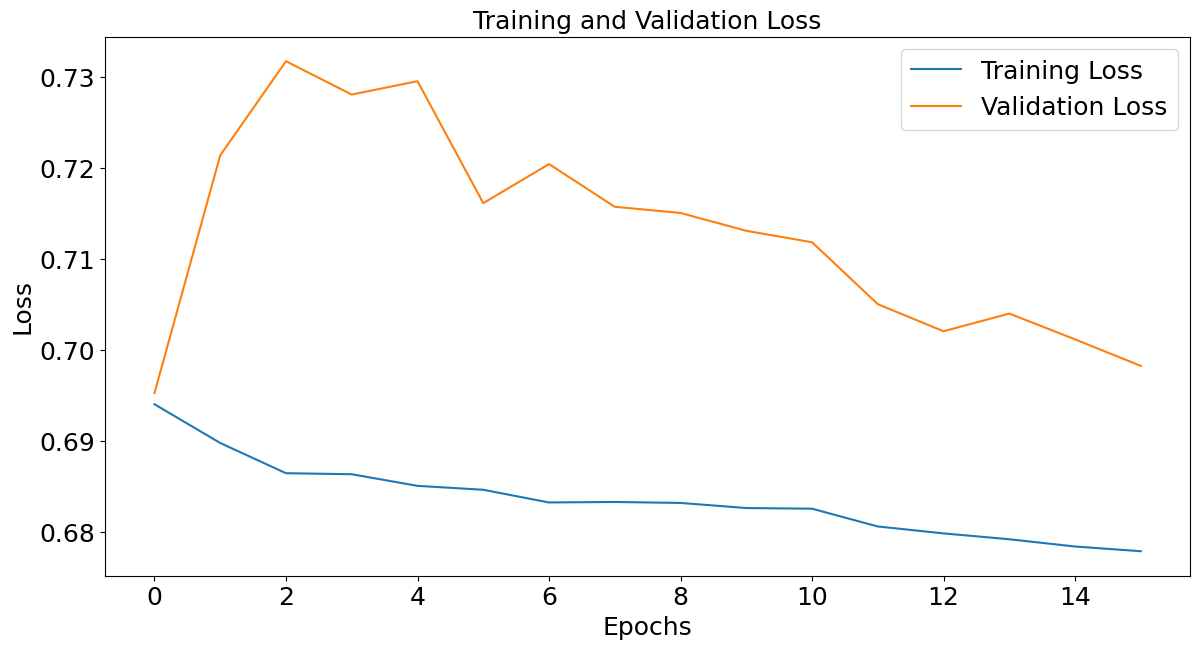

In [ ]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, Attention, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.regularizers import l2
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Load and preprocess the data
df = pd.read_csv('aapl_2014_2023.csv')
df['Date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='Date').reset_index(drop=True)
df.dropna(inplace=True)

# Encode the target column (convert strings to integers)
label_encoder = LabelEncoder()
df['target'] = label_encoder.fit_transform(df['target'])

# List of features (make sure 'target' is included as the last column)
FEATURES = ['close', 'open', 'high', 'low', 'volume', 'rsi_7', 'rsi_14', 'cci_7', 'cci_14', 'sma_50',
            'ema_50', 'sma_100', 'ema_100', 'macd', 'bollinger', 'TrueRange', 'atr_7', 'atr_14', 'target']
data_filtered = df[FEATURES]

# Scaling data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_filtered)

# Sequence length for time series
sequence_length = 10

# Partition dataset into input sequences (X) and target values (y)
def partition_dataset(sequence_length, data):
    x, y = [], []
    for i in range(sequence_length, len(data)):
        x.append(data[i-sequence_length:i, :])
        y.append(data[i, -1])  # 'target' is the last column
    return np.array(x), np.array(y)

x, y = partition_dataset(sequence_length, data_scaled)
split = int(0.8 * len(x))
x_train, y_train = x[:split], y[:split]
x_test, y_test = x[split:], y[split:]

# Learning Rate Scheduler
def lr_scheduler(epoch, lr):
    if epoch > 10:
        return lr * 0.9  # Slightly decrease learning rate after 10 epochs
    return lr

# Attention mechanism - Self-Attention Layer
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return attention

# Additional Attention Layer for hybrid approach (Post-CNN)
def post_cnn_attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return attention

# Build the enhanced LSTM-CNN model with hybrid attention and L2 regularization
def build_lstm_cnn_model(input_shape):
    inputs = Input(shape=input_shape)

    # First Bidirectional LSTM layer
    lstm_out = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    lstm_out = Dropout(0.05)(lstm_out)

    # Second Bidirectional LSTM layer
    lstm_out = Bidirectional(LSTM(84, return_sequences=True))(lstm_out)
    lstm_out = Dropout(0.05)(lstm_out)

    # Third Bidirectional LSTM layer
    lstm_out = Bidirectional(LSTM(52, return_sequences=True))(lstm_out)
    lstm_out = Dropout(0.05)(lstm_out)

    # Attention mechanism after LSTM layers (Self-Attention)
    attention_out = attention_layer(lstm_out)

    # Convolutional layer with max pooling
    cnn_out = Conv1D(filters=64, kernel_size=3, activation='relu')(attention_out)
    cnn_out = MaxPooling1D(pool_size=2)(cnn_out)

    # Hybrid Attention Mechanism: Apply attention after CNN
    post_cnn_attention_out = post_cnn_attention_layer(cnn_out)

    # Flatten the output of CNN + Attention before feeding into dense layers
    flat_out = Flatten()(post_cnn_attention_out)

    # Fully connected layers with L2 regularization
    dense_out = Dense(128, activation='relu', kernel_regularizer=l2(0.00001))(flat_out)
    dense_out = Dropout(0.01)(dense_out)
    dense_out = Dense(64, activation='relu', kernel_regularizer=l2(0.00001))(dense_out)
    outputs = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.00001))(dense_out)  # Sigmoid for binary classification

    model = Model(inputs, outputs)
    return model

# Initialize the model
model = build_lstm_cnn_model((x_train.shape[1], x_train.shape[2]))

# Compile the model with Adam optimizer and binary cross-entropy loss
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks: Early Stopping, ReduceLROnPlateau, and LearningRateScheduler for optimization
early_stop = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
lr_schedule = LearningRateScheduler(lr_scheduler)

# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=16, validation_split=0.1,
                    callbacks=[early_stop, reduce_lr, lr_schedule], verbose=1)

# Evaluate model performance
y_pred_scaled = model.predict(x_test)
y_pred = (y_pred_scaled > 0.5).astype(int)  # Convert probabilities to binary labels

# Metrics
mse = mean_squared_error(y_test, y_pred)
accuracy = np.mean(y_pred == y_test) * 100

# Results
print(f'MSE: {mse:.2f}')
print(f'Accuracy: {accuracy:.2f}%')

# Plot loss curve (training and validation loss)
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=18)
plt.tick_params(axis='both', labelsize=18)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, Attention, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.regularizers import l2
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Load and preprocess the data
df = pd.read_csv('nse_all_stock_data (1).csv')
df.head()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date').reset_index(drop=True)
df.dropna(inplace=True)
df.head(10)

,Date,RELIANCE,TCS,HDFCBANK,ICICIBANK,BHARTIARTL,SBIN,INFY,LICI,ITC,...,COOLCAPS,ALLETEC,20MICRONS,VIKASECO,ORIENTBELL,DONEAR,CAREERP,INTLCONV,SHREEPUSHK,PRITIKAUTO
